# Overview

## Aim
To interpret the simulation results, it is essential to compare the direction of the perturbation effect with the developmental flow of the trajectory. This comparison will allow us to assess the perturbation’s overall effect (i.e. block or promote differentiation), and  intuitively understand how TF is involved in cell fate determination during development.


## Method summary
For that purpose, we will introduce how to calculate the direction of differentiation using "pseudotime estimation" and "gradient calculation". Here's an overview of how to do this:

1. Calculate the pseudotime using the diffusion pseudotime method (dpt).
2. Transfer pseudotime data to grid points
3. Calculate the 2D gradient vector field using the pseudotime on the grid points
4. Compare the perturbation and pseudotime vector fields by computing their inner product values.


**In this notebook, we will do step1: pseudotime calculation.**
This step is divided into the following parts: 

1. Set the lineage information and split the cells into several lineage brahches.
2. Set root cells for each lineage.
3. Calculate pseudotime with DPT algorithm.
4. Re-aggregate scRNA-seq data into one data

## Custom class / object

`Pseudotime_calculator`: This is a class for the pseudotime calculation. This class help us calculate pseudotime from scRNA-seq data. We need to specify a root cell. Also, scRNA-seq need to have a diffusion map.
>Under the hood, the `Pseudotime_calculator` uses "dpt" algorithm.
For more information of dpt algorithm and root cell, please look at the scanpy web documentation.
https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html#scanpy.tl.dpt

## Data

Pseudo-time calculation requires preprocessed scRNA-seq data in anndata format.
You need to do neighbor calculation and diffusion map calculation in advance. If you have processed the scRNA-seq data according to our tutorial, these calculations have already been performed.
- Neighbor calculation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.neighbors.html#scanpy.pp.neighbors
- Diffusion map calculation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.diffmap.html#scanpy.tl.diffmap


## Install additional python package (This is an optional step.)

This notebook we recommend using another python package, `plotly`. 

Please install `plotly` in advance. 

`pip install plotly`

> Plotly is a toolkit for interactive visualization.
We recommend using plotly to pick up root cells in this notebook.
For more information, please look at plotly web site. https://plotly.com



## Caution
Here, we will introduce an example of a pseudotime calculation using the diffusion pseudotime method. This is NOT CellOracle analysis itself, but just a data preparation step.
In addition to the dpt method introduced here, CellOracle also accepts output from any pseudotime method.


## NOTE (YJK on Nov 2023)
- We need to add additional step during the RNA/ATAC data processing to compute (1) diffusion-based pseudotime (dpt) used in CellOracle, or (2) Slingshot.

- Note that Slingshot requires a good UMAP with fine-resolved trajectories of cells in 2D/3D embeddings. In Zebrahub v1.0, we used 3D UMAP to run Slingshot, which gave better-resolved cell fate trajectories than 2D UMAP.

- Palantir: Another psedotime computation algorithm from Dana Pe'er's lab. (python, compatible with SEACells, etc.)

# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import copy
import glob
import time
import os
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.auto import tqdm

## 0.2. Import our library

In [2]:
import celloracle as co
from celloracle.applications import Pseudotime_calculator
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.18.0'

## 0.3. Plotting parameter setting

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [5,5]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# 1. Load data

- If you have `Oracle` object, please run **1.1.[Option1] Load oracle data.**

- If you have not made an `Oracle` object yet and want to calculate pseudotime using `Anndata` object, please run **1.2.[Option2] Load anndata.** 

In this notebook, we will load demo `Oracle` object and add pseudotime information to it.

## 1.1. [Option1] Load oracle data

In [4]:
# Load the TDR118 oracle data
oracle = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR125reseq/06_TDR125reseq.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 11824
    n_genes: 3000
    cluster_name: manual_annotation
    dimensional_reduction_name: X_umap_aligned
    n_target_genes_in_TFdict: 13765 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 282 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1629 genes
    k_for_knn_imputation: 295
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [8]:
# import the pySlingshot pseudotime
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR125reseq_NMPs_pyslingshot.h5ad")
adata

AnnData object with n_obs × n_vars = 11824 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation', 'manual_clustering', 'manual_clustering_integer', 'Pseudotime', 'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [9]:
oracle.adata = adata

In [7]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/in_silico_KO_NMPs_subsets/"

## Compute the development vectors


###  Method overview

- As shown above, we can simulate how TF perturbations affect cell identity and visualize the results as a vector field map.

- To interpret the results, it is necessary to take into account the direction of natural differentiation. We will compare the simulated perturbation vectors with the developmental gradient vectors. By comparing them, we can intuitively understand how TFs impact cell fate determination during development. This perspective is also important for estimating the experimental perturbation results.

- Here, we will calculate the development vector field using **pseudotime gradient** as follows.
 
 1. Transfer the **pseudotime data** into an n x n digitized grid.

 2. Calculate the 2D gradient of pseudotime to get vector field.

 3. Compare the in silico TF perturbation vector field with the development vector field by calculating inner product between these two vectors. 


-  Note: Other methods may be used to represent a continuous scRNA-seq trajectory flow. For example, RNA velocity analysis is a good way to estimate the direction of cell differentiation. Choose the method that best suits your data.

- Note (YJK): There are several choices for how to compute the cell transition probabilities (cell-by-cell matrix, by CellRank). (1) RNA velocity (many methods), (2) pseudotime (also, different methods for computing the pseudotime. CellOracle uses Diffusion-based PseudoTime (DPT), but we can try Slingshot here, for consistency with Zebrahub).

## 4.1 Prepare pseudotime data

In the analysis below, we will use **pseudotime** data. Pseudotime data is included in the demo data. **If you are analyzing your own scRNA-seq data, please calculate pseudotime before starting this analysis.**

Refer to the following link below to see an example about calculating pseudotime for scRNA-seq data. 
https://morris-lab.github.io/CellOracle.documentation/tutorials/pseudotime.html




## 4.2. Check data

In [33]:
# oracle_pseudotime = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR118reseq/10_TDR118reseq_pseudotime.celloracle.oracle")
# oracle_pseudotime

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 8237
    n_genes: 3000
    cluster_name: manual_annotation
    dimensional_reduction_name: X_umap_aligned
    n_target_genes_in_TFdict: 13576 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 327 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1620 genes
    k_for_knn_imputation: 205
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

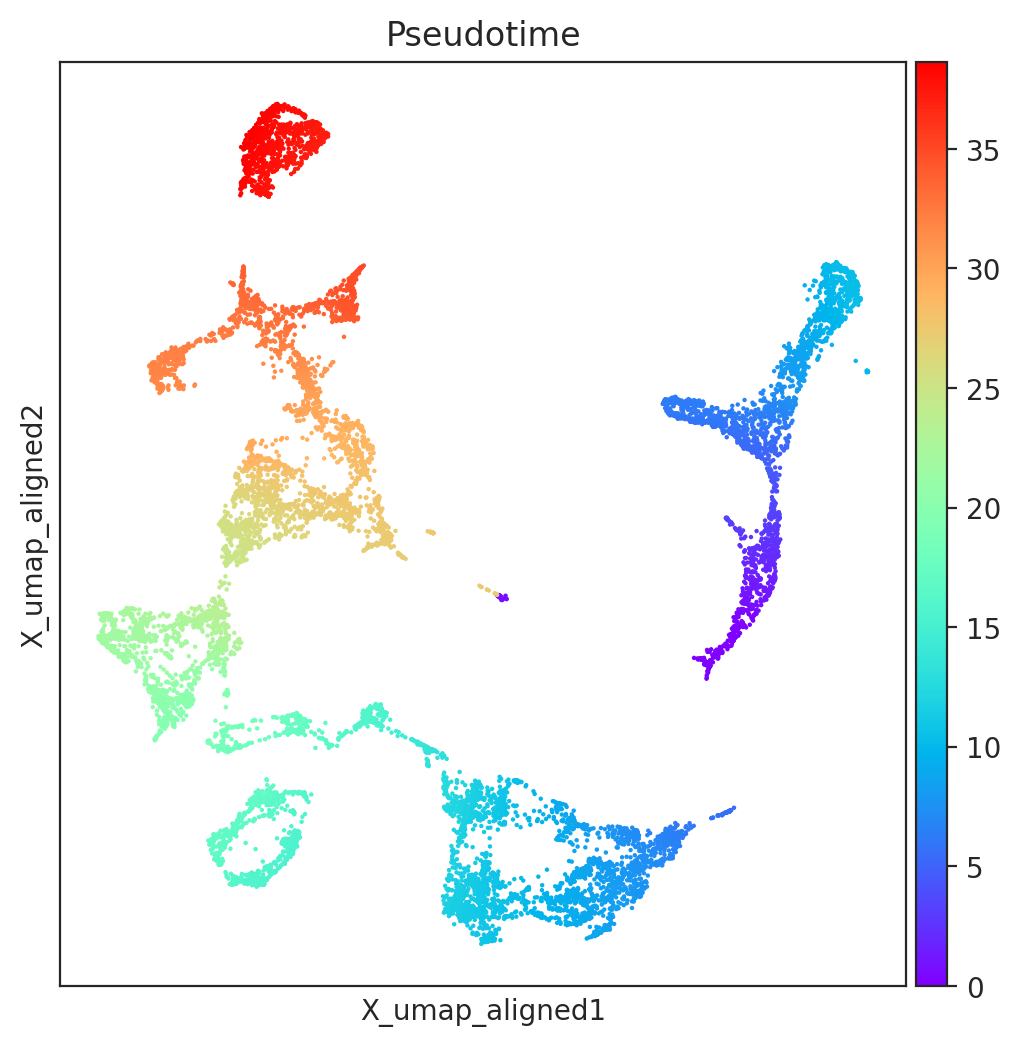

In [10]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["Pseudotime"])

## 5.3. Make Gradient_calculator object

In [11]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")

We need to set `n_grid` and `min_mass` for the pseudotime grid point calculation too.
`n_grid`: Number of grid point.

We already know approproate values for them. Please set the same values as step 4.2.1 above. (From the "TDR118_KO_simulation.ipynb notebook within 02_GRN/05_simulation/ directory).


## 4.2. Vector field graph

We will visualize the simulation results as a vector field on a digitized grid. Single cell transition vectors are grouped by grid point.

### 4.2.1  Find parameters for n_grid and min_mass
`n_grid`: Number of grid points.

`min_mass`: Threshold value for the cell density. 
The appropriate values for these parameters depends on the data. Please find appropriate values using the helper functions below.
 


In [13]:
# n_grid = 40 is a good starting value.
n_grid = 40 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=50)

AttributeError: 'Oracle' object has no attribute 'delta_embedding'

Please run `oracle.suggest_mass_thresholds()` to display a range of `min_mass` parameter values and choose a value to fit the data.

In [14]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

AttributeError: 'Oracle' object has no attribute 'total_p_mass'

According to the results, the optimal `min_mass` is around 0.011.

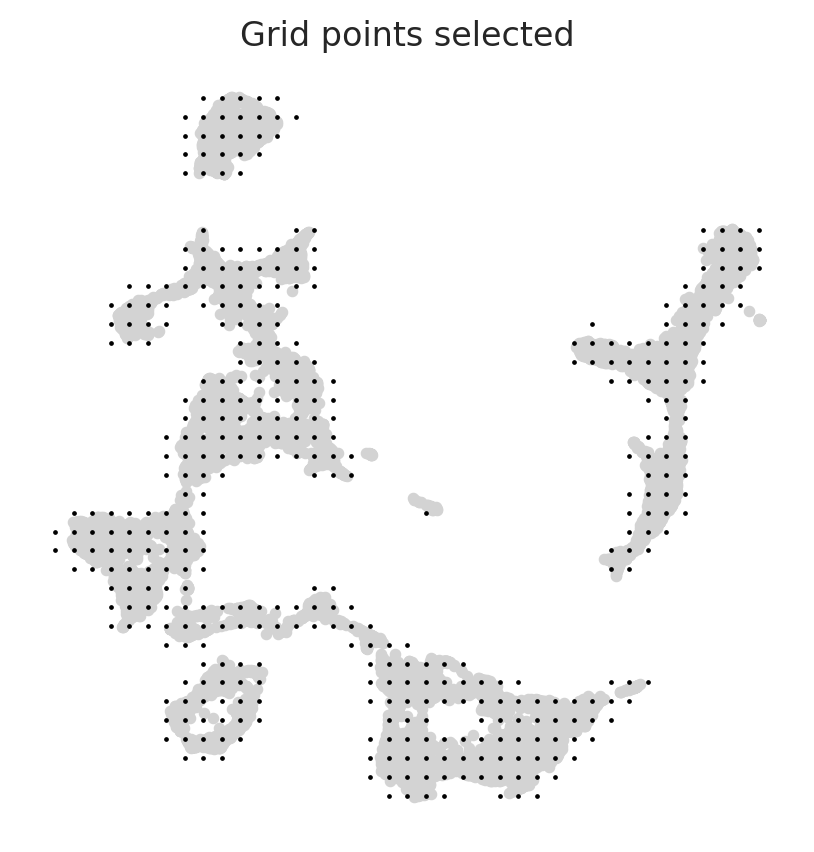

In [15]:
min_mass=26
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=300)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

## 5.4 Transfer pseudotime values to the grid points.

Next, we convert the pseudotime data into grid points. For this calculation we can chose one of two methods.

- `knn`: K-Nearesr Neighbor regression. You will need to set number of neighbors.
  Please adjust `n_knn` for best results.This will depend on the population size and density of your scRNA-seq data.

 `gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})`



- `polynomial`: Polynomial regression using x-axis and y-axis of dimensional reduction space.

 In general, this method will be more robust. Please use this method if knn method does not work.
 `n_poly` is the number of degrees for the polynomial regression model. Please try to find appropriate`n_poly` searching for best results.
 
 `gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3})`

In [16]:
# number of k-nearest neighbors(knn)
n_knn = oracle.k_knn_imputation

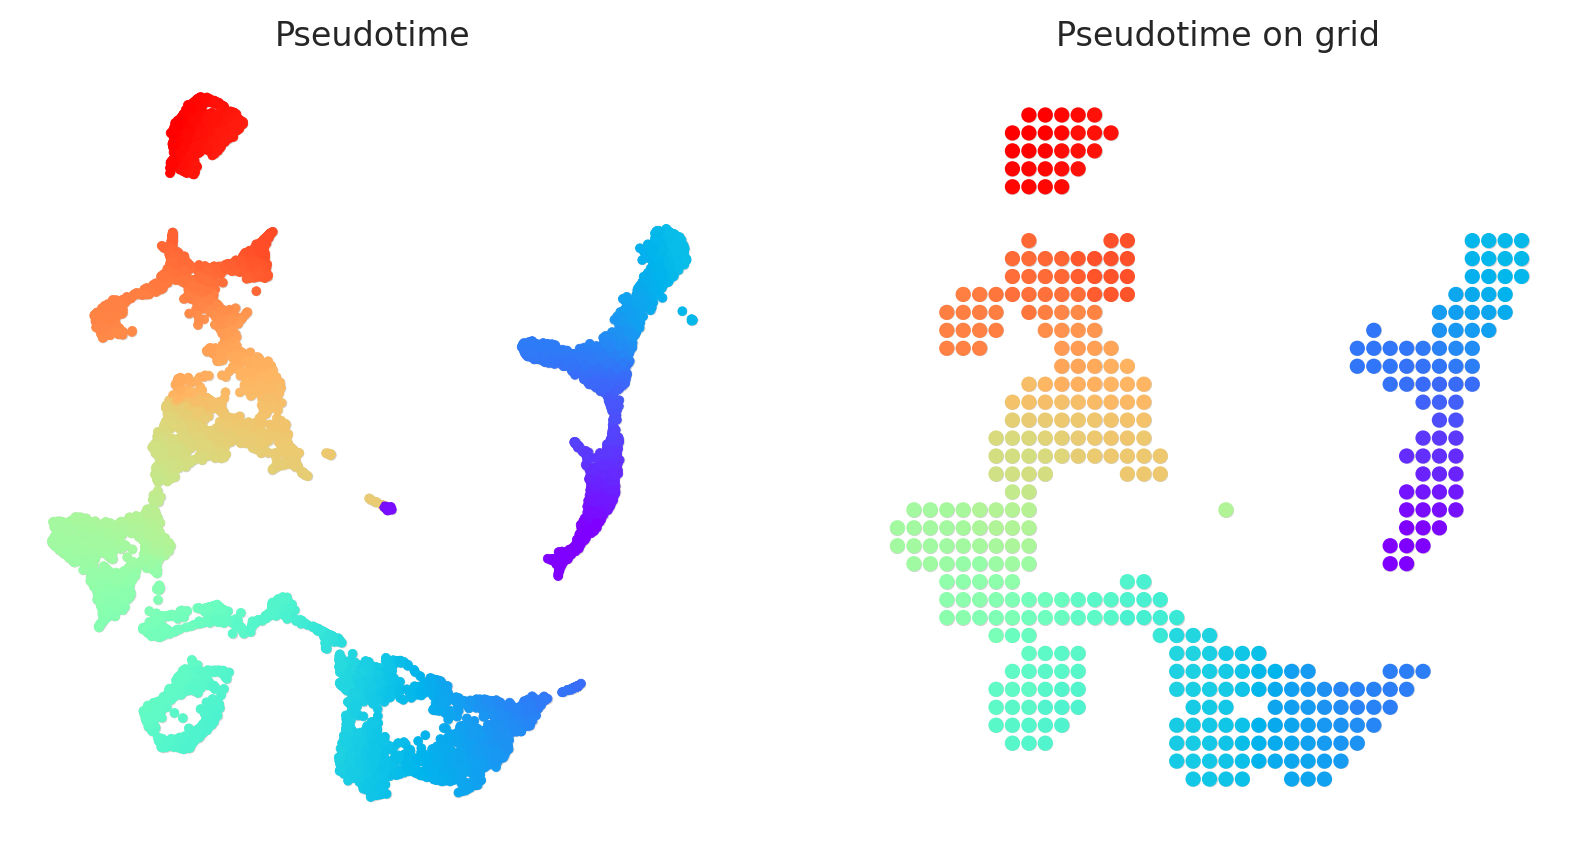

In [17]:
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":n_knn}, plot=True)

## 5.5. Calculate Gradient vectors

Calculate the 2D vector map to represents the pseudotime gradient. After the gradient calculation, the length of the vector will be normalized automatically.

Please adjust the `scale` parameter to adjust vector length visualization.

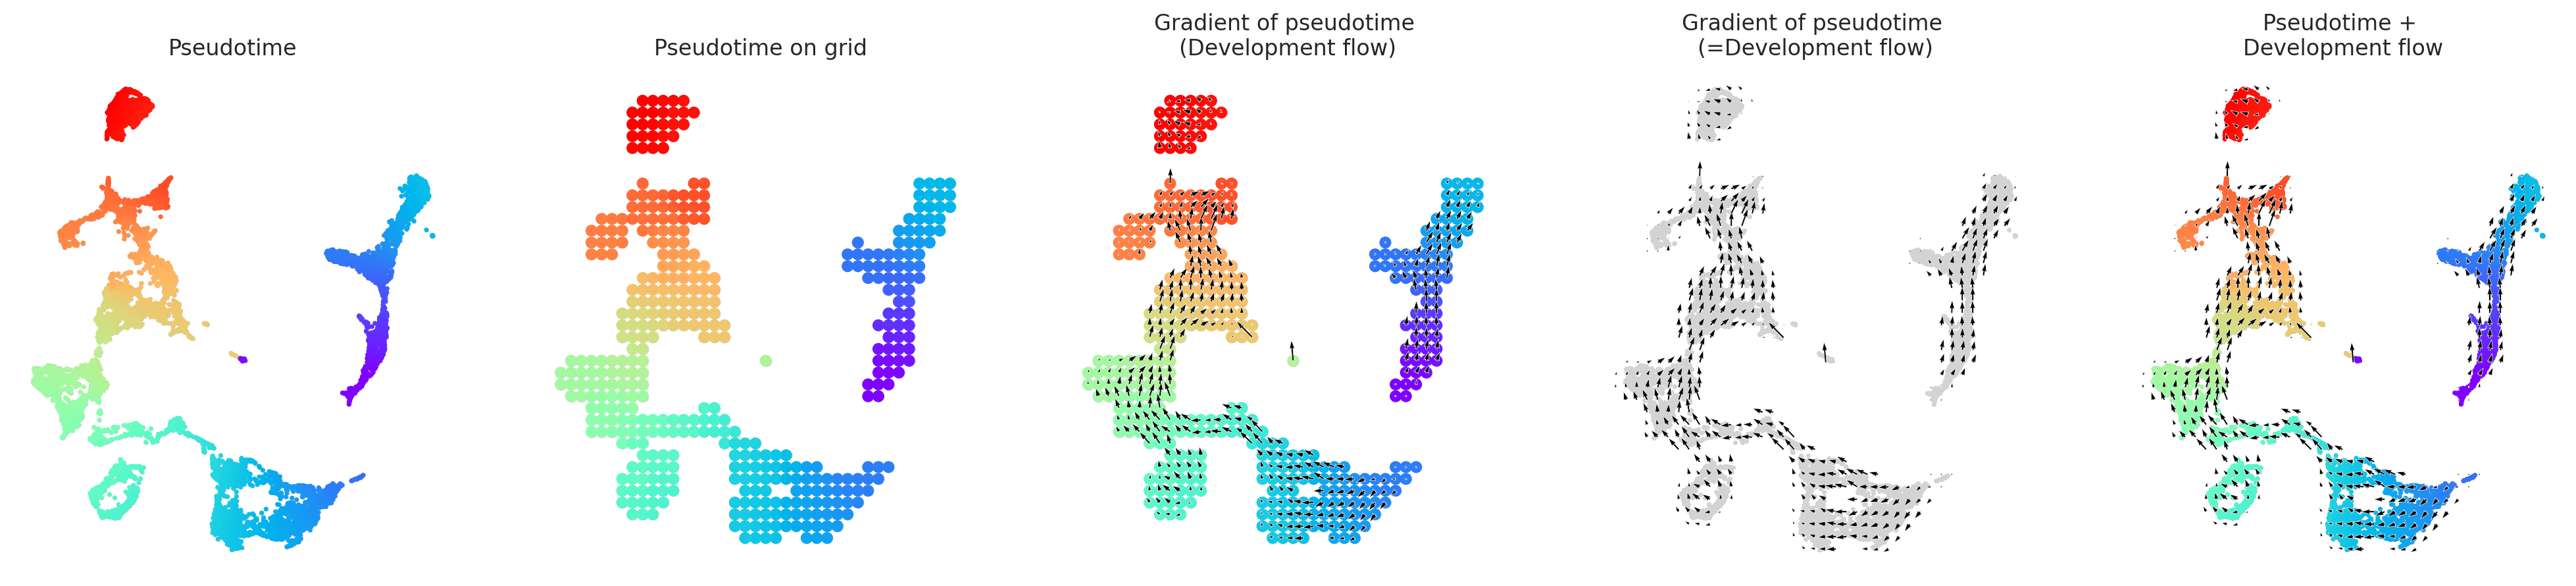

In [18]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

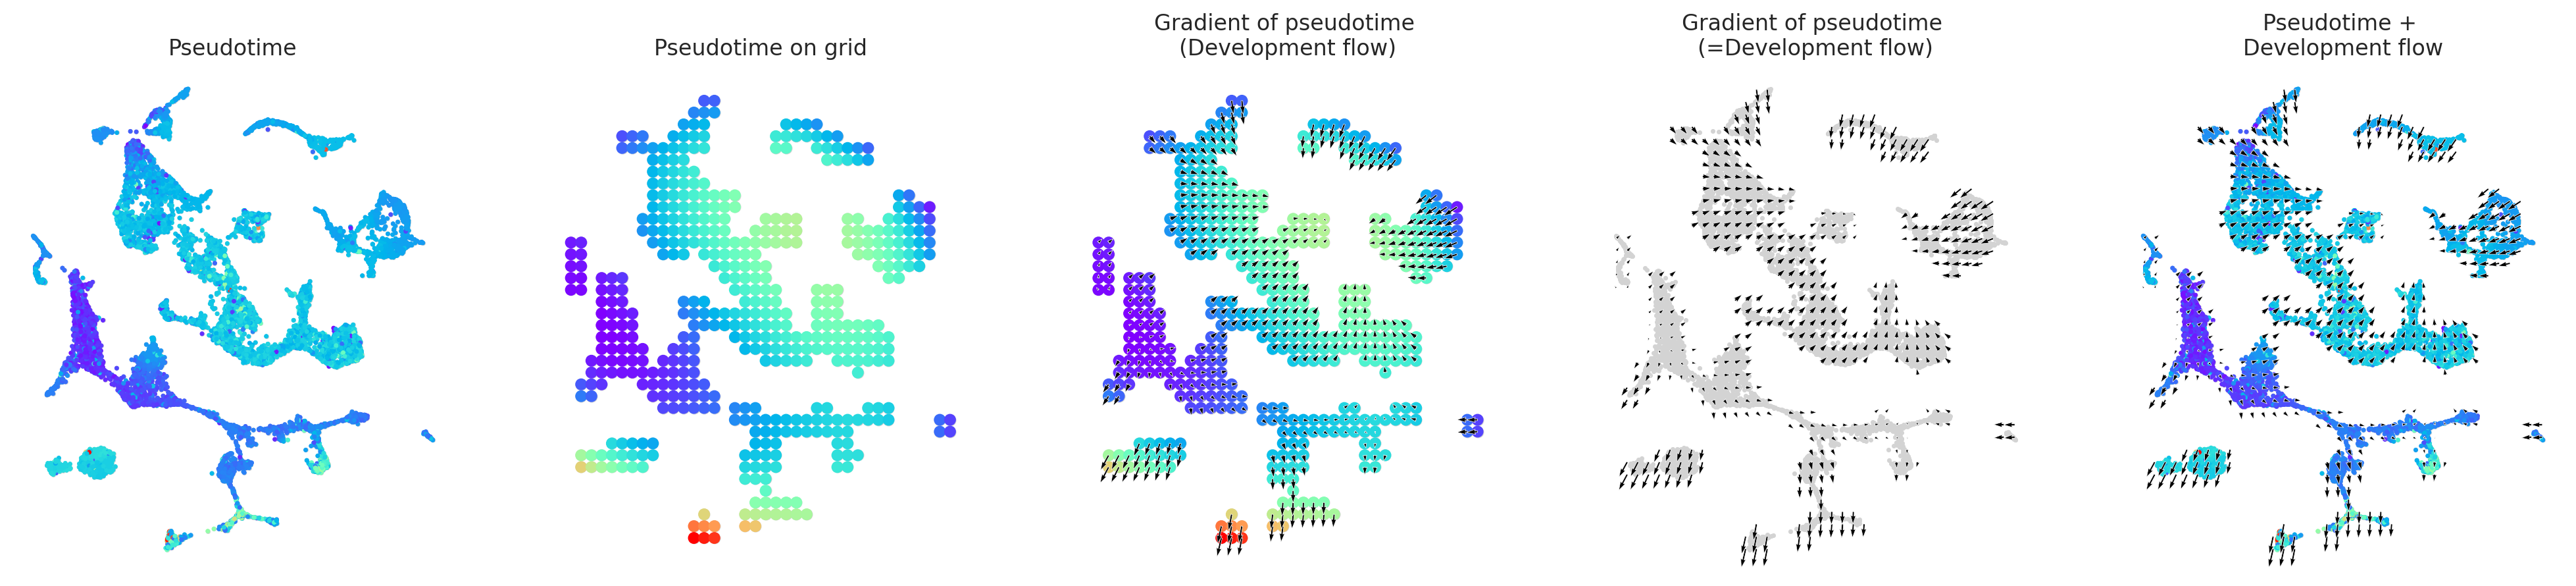

In [49]:
# # Calculate graddient
# gradient.calculate_gradient()

# # Show results
# scale_dev = 40
# gradient.visualize_results(scale=scale_dev, s=5)

In [19]:
def generate_colorandum(oracle, annotation, cell_types):
    """
    Generate the colorandum for the cell types
    """
    # Generate "Set3" color palette
    set3_palette = sns.color_palette("Set3", n_colors=len(cell_types))

    # Suppose the light yellow is the 10th color in the palette (9th index, as indexing is 0-based)
    # and you want to replace it with teal color
    teal_color = (0.0, 0.5019607843137255, 0.5019607843137255)  # RGB for teal
    set3_palette[1] = teal_color  # Replace the light yellow with teal

    # Assign colors to cell types
    custom_palette = {cell_type: color for cell_type, color in zip(cell_types, set3_palette)}
    # Change the color for 'NMPs' to a dark blue
    custom_palette['NMPs'] = (0.12941176470588237, 0.4, 0.6745098039215687)  # Dark blue color

    # Get the order of categories as they appear in the dataset
    categories_in_order = oracle.adata.obs[annotation].cat.categories

    # Reorder your palette dictionary to match this order
    ordered_palette = {cat: custom_palette[cat] for cat in categories_in_order if cat in custom_palette}

    # Now assign this ordered palette back to the AnnData object
    annotation_color = annotation + "_color"
    oracle.adata.uns[annotation_color] = ordered_palette

    # Change the color palette in the Oracle object
    # Extract the cell type annotations from the AnnData object
    cell_types = oracle.adata.obs[annotation].values

    # Map each cell type to its corresponding color
    colors_for_cells = np.array([custom_palette[cell_type] for cell_type in cell_types])

    # Replace the colorandum in the oracle object
    oracle.colorandum = colors_for_cells

    return oracle

In [20]:
# Optional: Change the color palette
# Cell types
cell_types = [
    'Epidermal', 'Lateral_Mesoderm', 'PSM', 'Neural_Posterior',
    'Neural_Anterior', 'Neural_Crest', 'Differentiating_Neurons',
    'Adaxial_Cells', 'Muscle', 'Somites', 'Endoderm', 'Notochord',
    'NMPs'
]
oracle = generate_colorandum(oracle, "manual_annotation", cell_types)

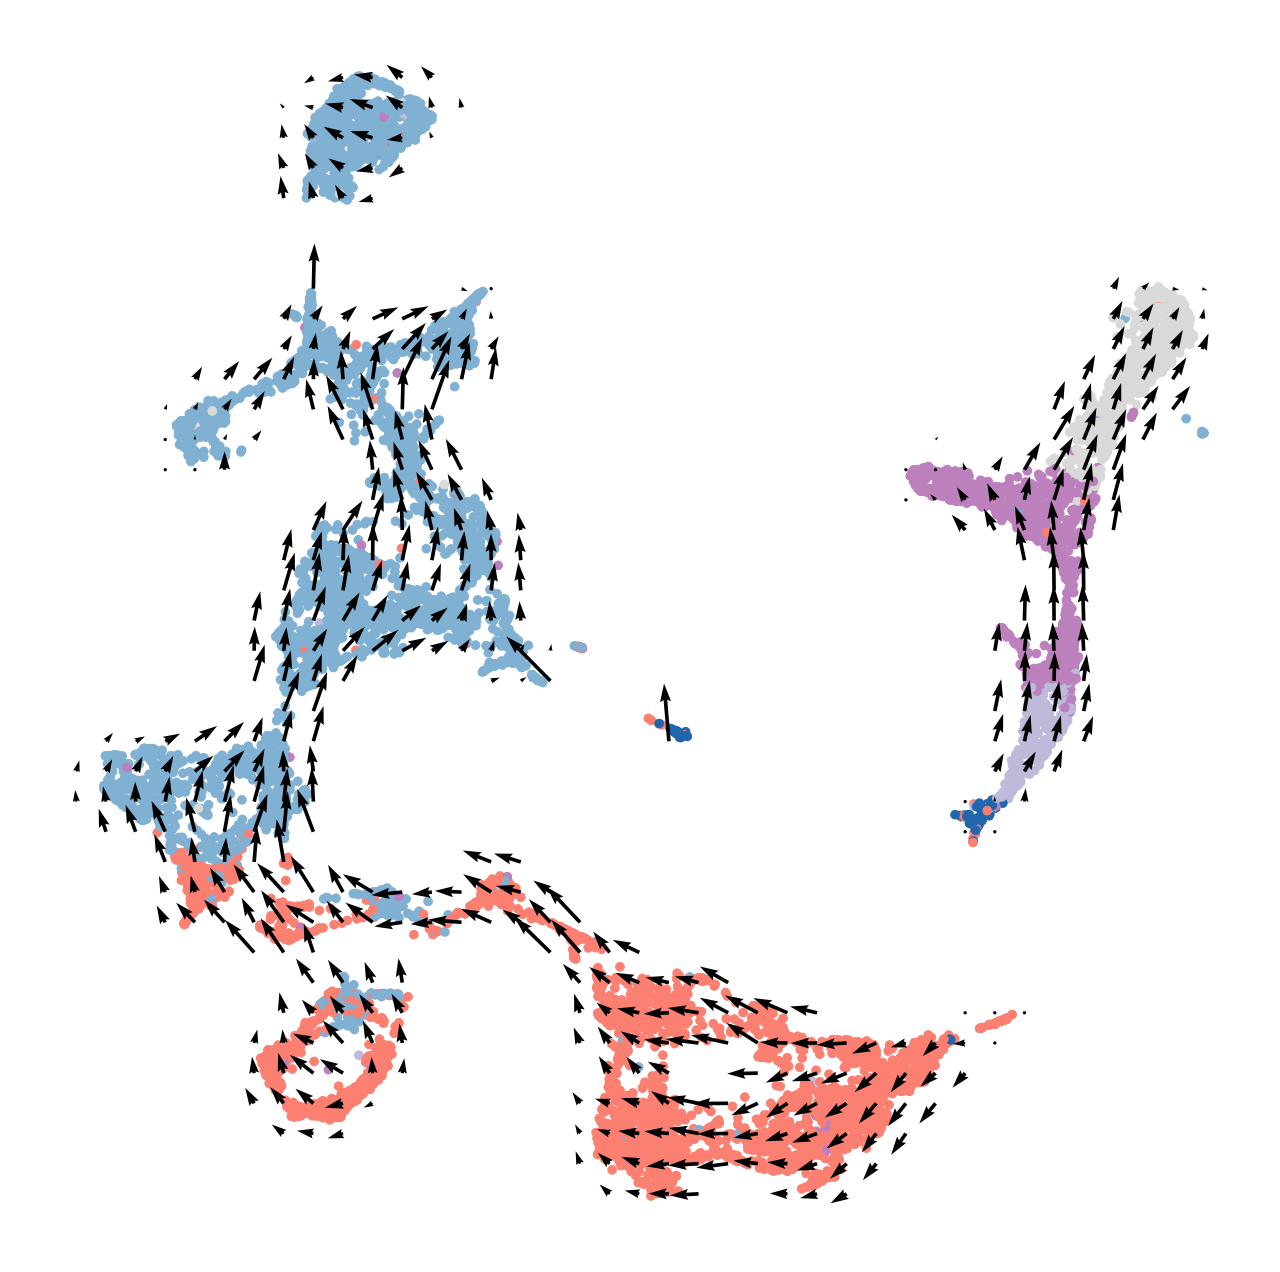

In [22]:
data_id = "TDR125reseq"

fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
gradient.plot_dev_flow_on_grid(scale=40, ax=ax, show_background=False)
plt.savefig(figpath + f"umap_nmps_{data_id}_dev_flow.png")
plt.savefig(figpath + f"umap_nmps_{data_id}_dev_flow.pdf")

In [24]:
# Save gradient object if you want.
oracle_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR125reseq/"
gradient.to_hdf5(oracle_path + f"11_{data_id}_pseudotime_knn.celloracle.gradient")

## TDR124reseq (30-somites)

In [27]:
# Load the TDR124reseq oracle data
oracle = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR124reseq/06_TDR124reseq.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 4967
    n_genes: 3000
    cluster_name: manual_annotation
    dimensional_reduction_name: X_umap_aligned
    n_target_genes_in_TFdict: 13359 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 289 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1677 genes
    k_for_knn_imputation: 124
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [28]:
# import the pySlingshot pseudotime
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR124reseq_NMPs_pyslingshot.h5ad")
adata

AnnData object with n_obs × n_vars = 4967 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation', 'manual_clustering', 'manual_clustering_integer', 'Pseudotime', 'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [29]:
oracle.adata = adata

In [30]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/in_silico_KO_NMPs_subsets/"

## Compute the development vectors


###  Method overview

- As shown above, we can simulate how TF perturbations affect cell identity and visualize the results as a vector field map.

- To interpret the results, it is necessary to take into account the direction of natural differentiation. We will compare the simulated perturbation vectors with the developmental gradient vectors. By comparing them, we can intuitively understand how TFs impact cell fate determination during development. This perspective is also important for estimating the experimental perturbation results.

- Here, we will calculate the development vector field using **pseudotime gradient** as follows.
 
 1. Transfer the **pseudotime data** into an n x n digitized grid.

 2. Calculate the 2D gradient of pseudotime to get vector field.

 3. Compare the in silico TF perturbation vector field with the development vector field by calculating inner product between these two vectors. 


-  Note: Other methods may be used to represent a continuous scRNA-seq trajectory flow. For example, RNA velocity analysis is a good way to estimate the direction of cell differentiation. Choose the method that best suits your data.

- Note (YJK): There are several choices for how to compute the cell transition probabilities (cell-by-cell matrix, by CellRank). (1) RNA velocity (many methods), (2) pseudotime (also, different methods for computing the pseudotime. CellOracle uses Diffusion-based PseudoTime (DPT), but we can try Slingshot here, for consistency with Zebrahub).

## 4.1 Prepare pseudotime data

In the analysis below, we will use **pseudotime** data. Pseudotime data is included in the demo data. **If you are analyzing your own scRNA-seq data, please calculate pseudotime before starting this analysis.**

Refer to the following link below to see an example about calculating pseudotime for scRNA-seq data. 
https://morris-lab.github.io/CellOracle.documentation/tutorials/pseudotime.html




## 4.2. Check data

In [33]:
# oracle_pseudotime = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR118reseq/10_TDR118reseq_pseudotime.celloracle.oracle")
# oracle_pseudotime

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 8237
    n_genes: 3000
    cluster_name: manual_annotation
    dimensional_reduction_name: X_umap_aligned
    n_target_genes_in_TFdict: 13576 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 327 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1620 genes
    k_for_knn_imputation: 205
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

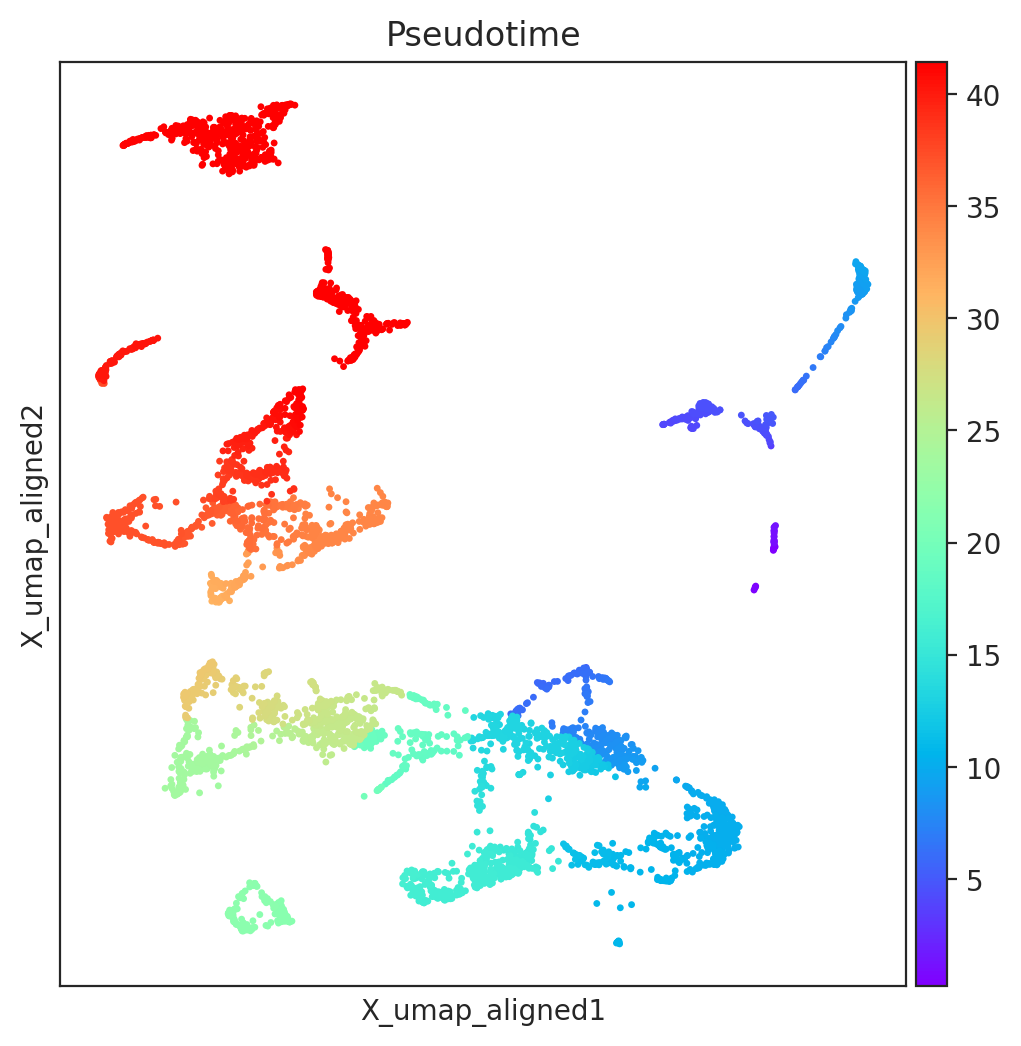

In [31]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["Pseudotime"])

## 5.3. Make Gradient_calculator object

In [32]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")

We need to set `n_grid` and `min_mass` for the pseudotime grid point calculation too.
`n_grid`: Number of grid point.

We already know approproate values for them. Please set the same values as step 4.2.1 above. (From the "TDR118_KO_simulation.ipynb notebook within 02_GRN/05_simulation/ directory).


## 4.2. Vector field graph

We will visualize the simulation results as a vector field on a digitized grid. Single cell transition vectors are grouped by grid point.

### 4.2.1  Find parameters for n_grid and min_mass
`n_grid`: Number of grid points.

`min_mass`: Threshold value for the cell density. 
The appropriate values for these parameters depends on the data. Please find appropriate values using the helper functions below.
 


In [13]:
# n_grid = 40 is a good starting value.
n_grid = 40 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=50)

AttributeError: 'Oracle' object has no attribute 'delta_embedding'

Please run `oracle.suggest_mass_thresholds()` to display a range of `min_mass` parameter values and choose a value to fit the data.

In [14]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

AttributeError: 'Oracle' object has no attribute 'total_p_mass'

According to the results, the optimal `min_mass` is around 0.011.

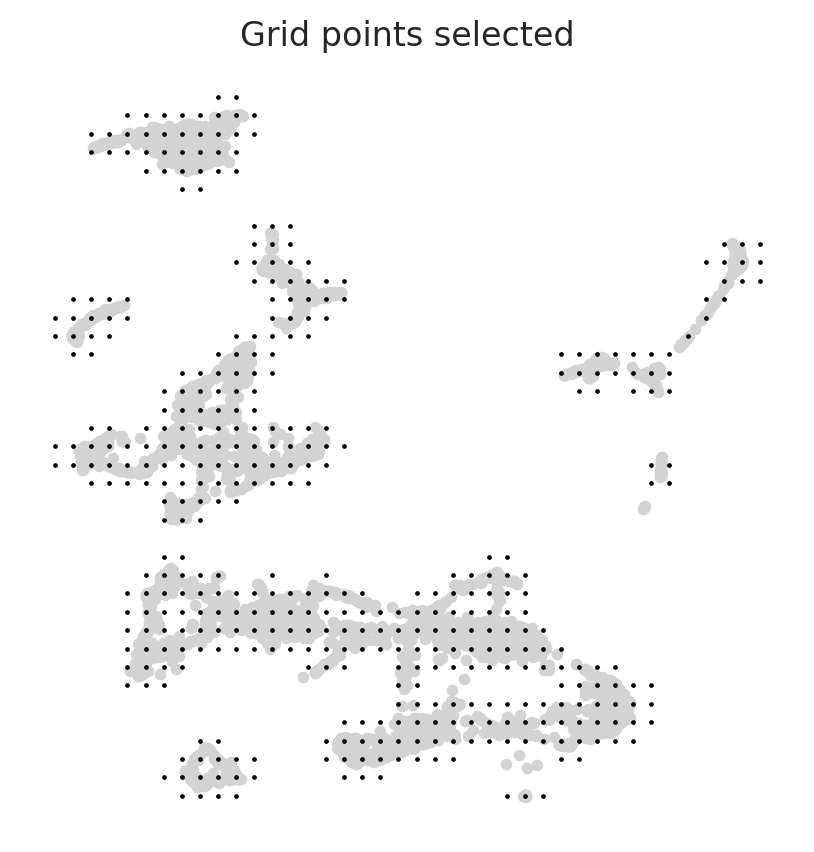

In [39]:
min_mass=10
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=300)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

## 5.4 Transfer pseudotime values to the grid points.

Next, we convert the pseudotime data into grid points. For this calculation we can chose one of two methods.

- `knn`: K-Nearesr Neighbor regression. You will need to set number of neighbors.
  Please adjust `n_knn` for best results.This will depend on the population size and density of your scRNA-seq data.

 `gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})`



- `polynomial`: Polynomial regression using x-axis and y-axis of dimensional reduction space.

 In general, this method will be more robust. Please use this method if knn method does not work.
 `n_poly` is the number of degrees for the polynomial regression model. Please try to find appropriate`n_poly` searching for best results.
 
 `gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3})`

In [41]:
# number of k-nearest neighbors(knn)
n_knn = oracle.k_knn_imputation
print(n_knn)

124


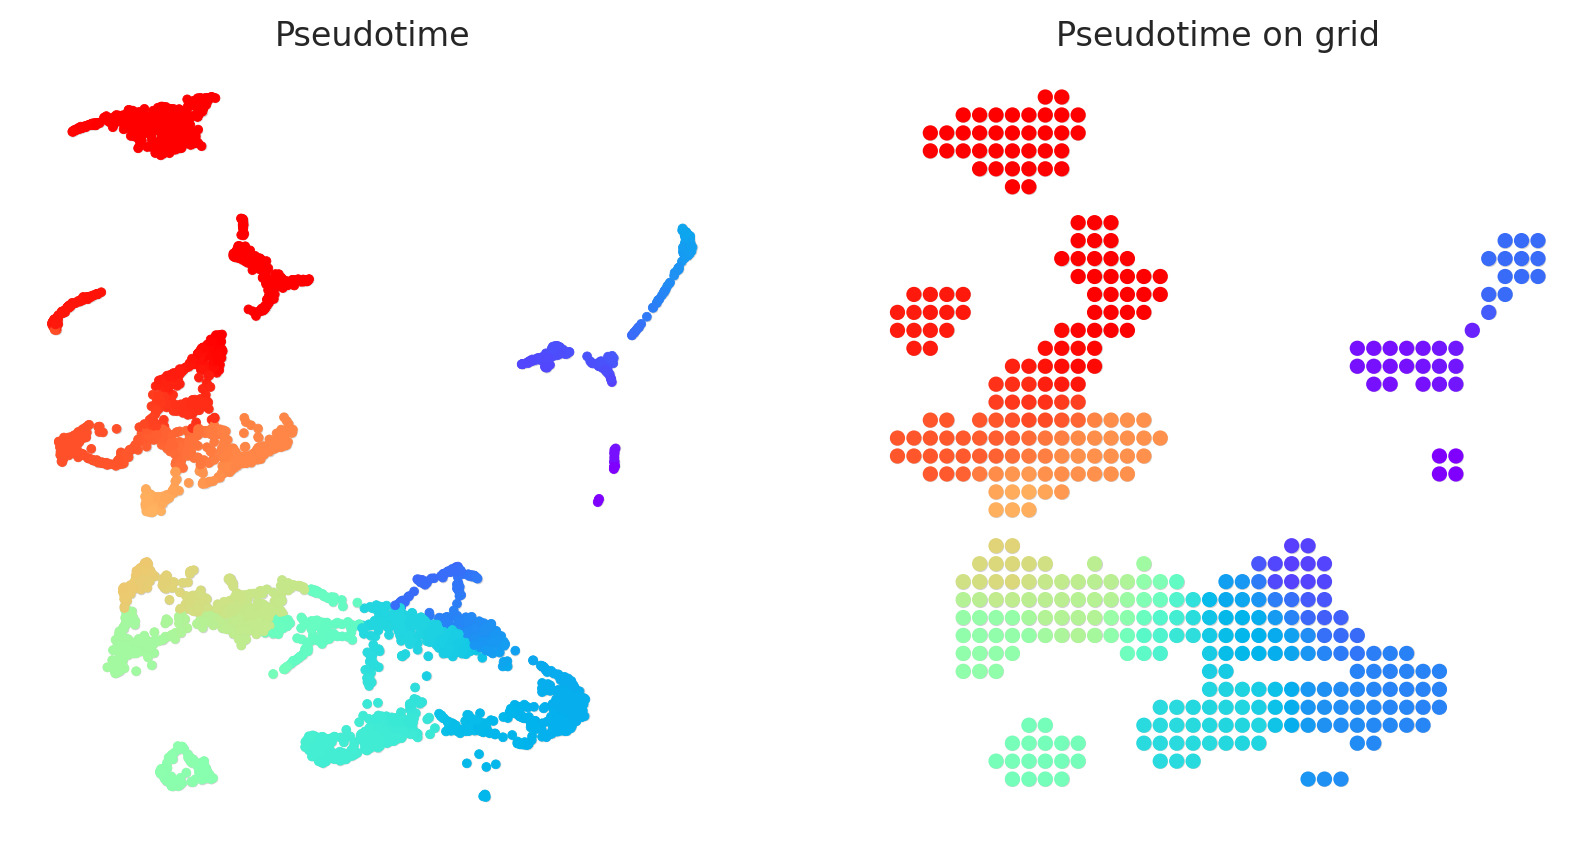

In [42]:
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":n_knn}, plot=True)

## 5.5. Calculate Gradient vectors

Calculate the 2D vector map to represents the pseudotime gradient. After the gradient calculation, the length of the vector will be normalized automatically.

Please adjust the `scale` parameter to adjust vector length visualization.

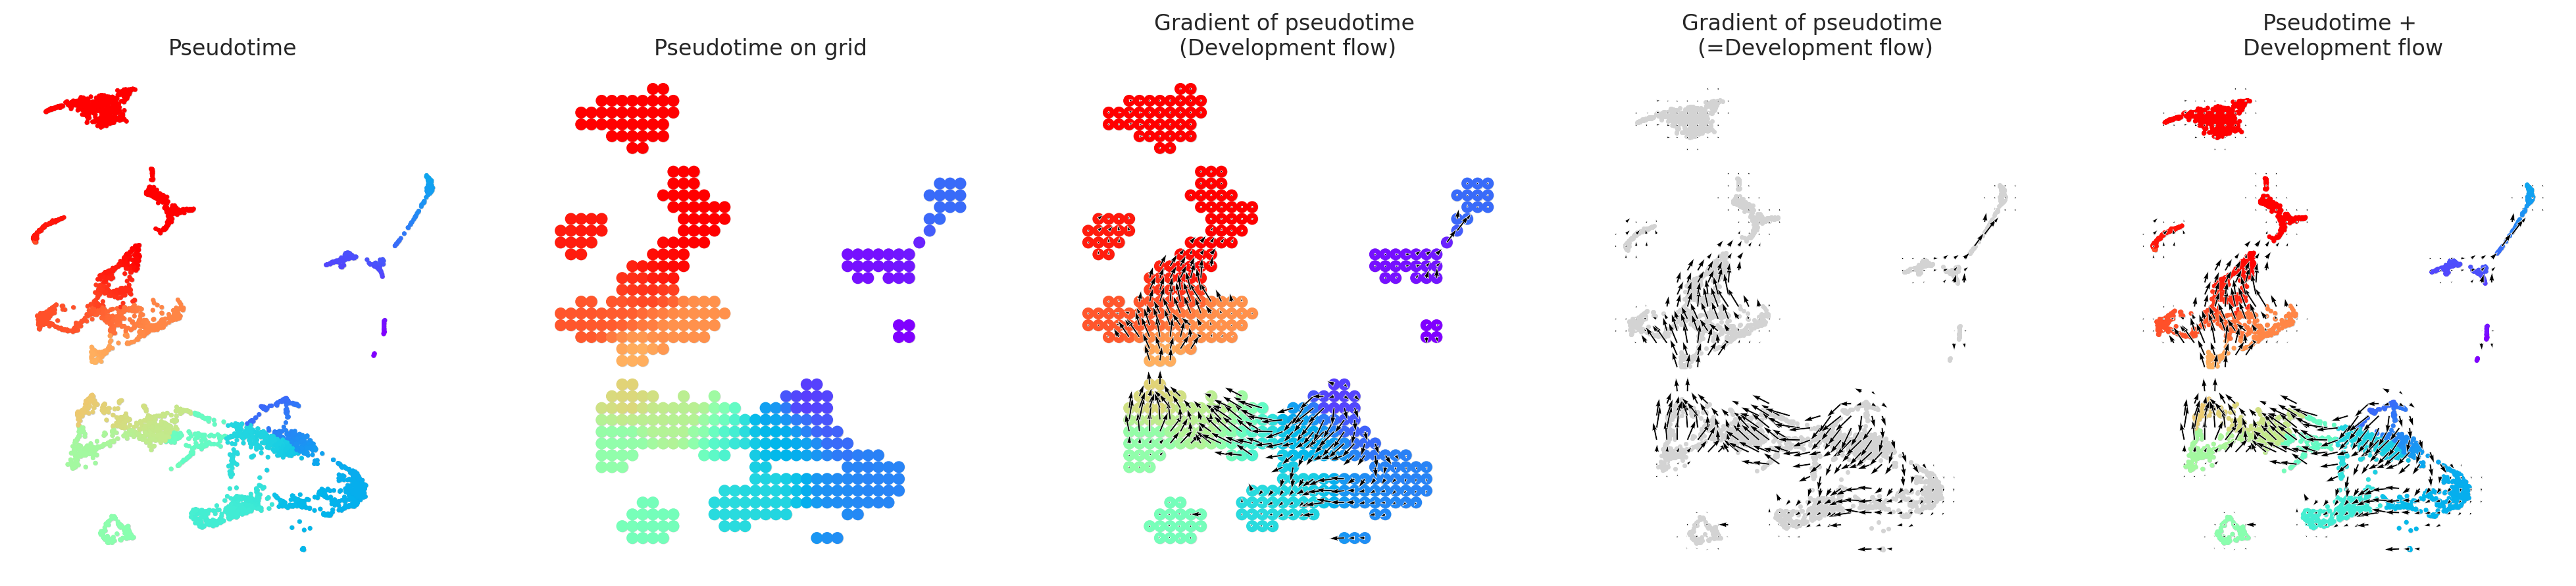

In [43]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

In [19]:
def generate_colorandum(oracle, annotation, cell_types):
    """
    Generate the colorandum for the cell types
    """
    # Generate "Set3" color palette
    set3_palette = sns.color_palette("Set3", n_colors=len(cell_types))

    # Suppose the light yellow is the 10th color in the palette (9th index, as indexing is 0-based)
    # and you want to replace it with teal color
    teal_color = (0.0, 0.5019607843137255, 0.5019607843137255)  # RGB for teal
    set3_palette[1] = teal_color  # Replace the light yellow with teal

    # Assign colors to cell types
    custom_palette = {cell_type: color for cell_type, color in zip(cell_types, set3_palette)}
    # Change the color for 'NMPs' to a dark blue
    custom_palette['NMPs'] = (0.12941176470588237, 0.4, 0.6745098039215687)  # Dark blue color

    # Get the order of categories as they appear in the dataset
    categories_in_order = oracle.adata.obs[annotation].cat.categories

    # Reorder your palette dictionary to match this order
    ordered_palette = {cat: custom_palette[cat] for cat in categories_in_order if cat in custom_palette}

    # Now assign this ordered palette back to the AnnData object
    annotation_color = annotation + "_color"
    oracle.adata.uns[annotation_color] = ordered_palette

    # Change the color palette in the Oracle object
    # Extract the cell type annotations from the AnnData object
    cell_types = oracle.adata.obs[annotation].values

    # Map each cell type to its corresponding color
    colors_for_cells = np.array([custom_palette[cell_type] for cell_type in cell_types])

    # Replace the colorandum in the oracle object
    oracle.colorandum = colors_for_cells

    return oracle

In [20]:
# Optional: Change the color palette
# Cell types
cell_types = [
    'Epidermal', 'Lateral_Mesoderm', 'PSM', 'Neural_Posterior',
    'Neural_Anterior', 'Neural_Crest', 'Differentiating_Neurons',
    'Adaxial_Cells', 'Muscle', 'Somites', 'Endoderm', 'Notochord',
    'NMPs'
]
oracle = generate_colorandum(oracle, "manual_annotation", cell_types)

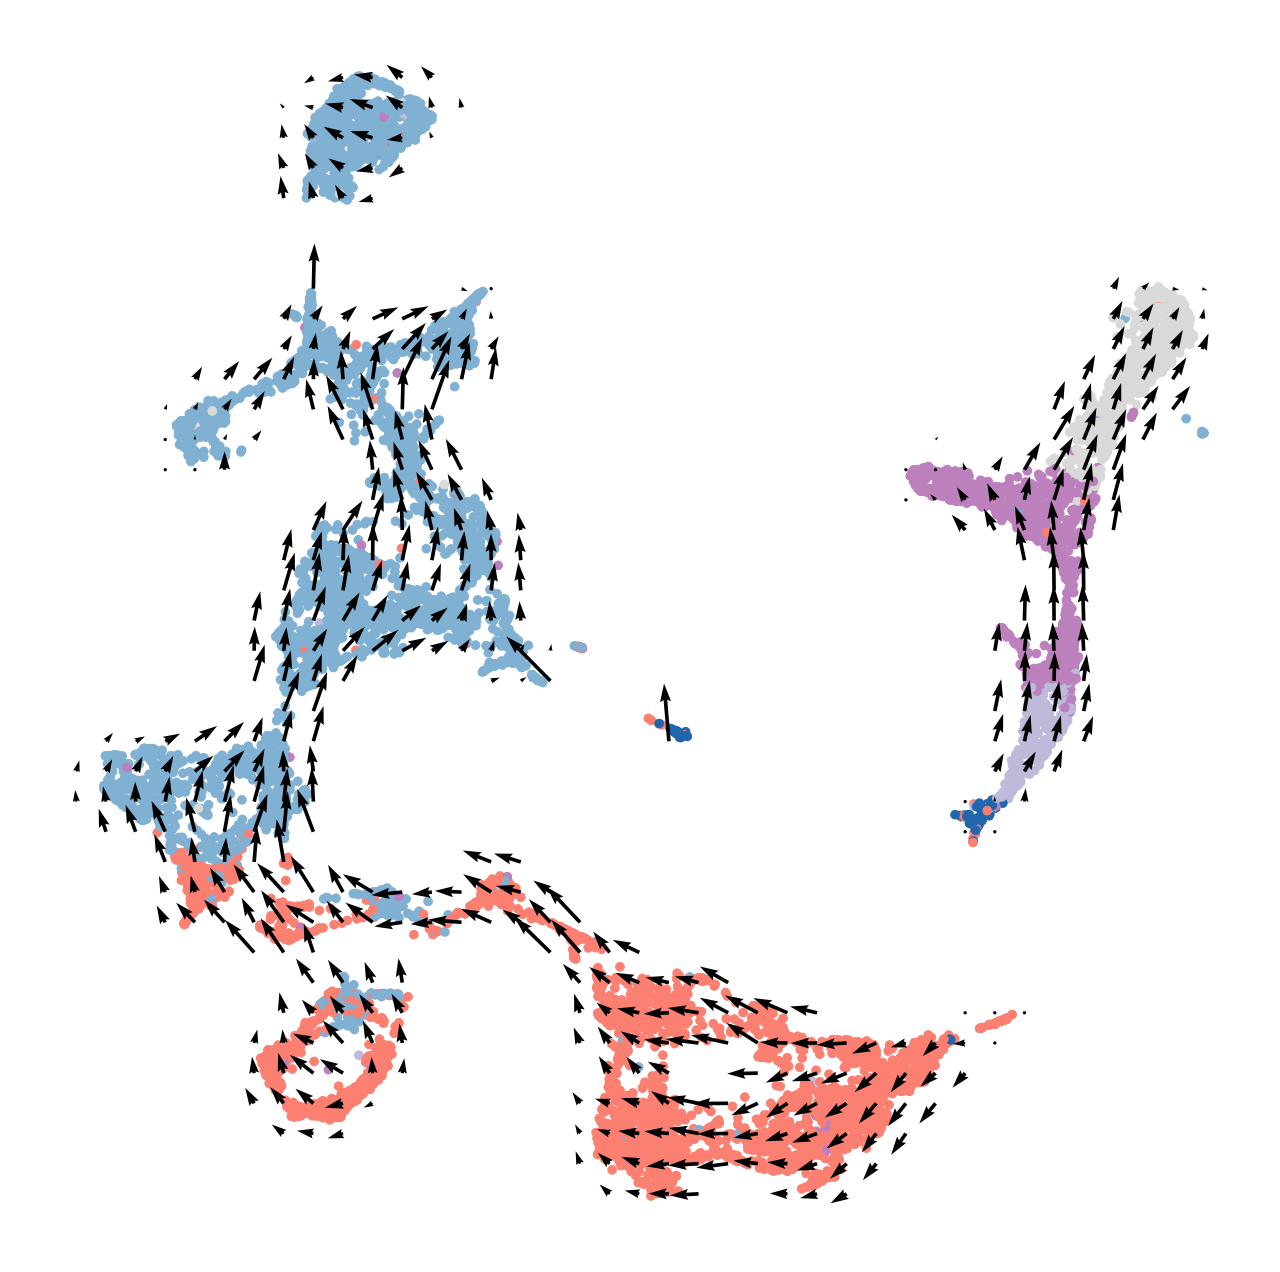

In [22]:
data_id = "TDR125reseq"

fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
gradient.plot_dev_flow_on_grid(scale=40, ax=ax, show_background=False)
plt.savefig(figpath + f"umap_nmps_{data_id}_dev_flow.png")
plt.savefig(figpath + f"umap_nmps_{data_id}_dev_flow.pdf")

In [24]:
# Save gradient object if you want.
oracle_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR125reseq/"
gradient.to_hdf5(oracle_path + f"11_{data_id}_pseudotime_knn.celloracle.gradient")